In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import atlite
import numpy as np
import logging 
logging.basicConfig(level=logging.INFO)
import xesmf as xe

/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2", "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]
variants = ["r1i1p1f1", "r1i1p2f1", "r1i1p1f1", "r1i1p1f1", "r1i1p1f3", "r1i1p1f3", "r1i1p1f1"]
period = ["historical","ssp585"]

In [6]:
filename_era5="/groups/EXTREMES/cutouts/europe-1988-era5.nc"
# read in cutout instead of creating it
cutout = atlite.Cutout(path=filename_era5)
power_era5_1988=cutout.pv(
    panel='CSi', 
    orientation='latitude_optimal',
    tracking=None,
)

INFO:atlite.convert:Convert and aggregate 'pv'.


In [7]:
solar_power_era5=power_era5_1988.sel(x=slice(-12,35), y=slice(33,64.8))

In [3]:
# Define the list of models
models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2", "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]

# Define the base path where the model files are stored
base_path = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"

# Define the region to slice
region = {
    'lon_min': -12,
    'lon_max': 35,
    'lat_min': 33,
    'lat_max': 64.8
}

In [4]:
import os
def compute_global_min_max(models, base_path, region, solar_power_era5):
    """
    Compute the global minimum and maximum values of solar power across all models and solar_power_era5.

    Parameters:
    - models: list of str, names of the models to process.
    - base_path: str, base directory containing the model files.
    - region: dict, region to slice with keys 'lon_min', 'lon_max', 'lat_min', 'lat_max'.
    - solar_power_era5: xarray.DataArray, the ERA5 solar power data.

    Returns:
    - vmin: float, global minimum value.
    - vmax: float, global maximum value.
    """
    global_min = []
    global_max = []

    # Include solar_power_era5 in the computation
    era5_min = solar_power_era5.sel(
        x=slice(region['lon_min'], region['lon_max']),
        y=slice(region['lat_min'], region['lat_max'])
    ).min().item()
    era5_max = solar_power_era5.sel(
        x=slice(region['lon_min'], region['lon_max']),
        y=slice(region['lat_min'], region['lat_max'])
    ).max().item()

    global_min.append(era5_min)
    global_max.append(era5_max)

    # Compute min and max for each model
    for model in models:
        try:
            power_file = os.path.join(base_path, model, "historical", "aggregated_solar_power_1988.nc")
            ds_power = xr.open_dataset(power_file)
            solar_power = ds_power['specific generation'].sel(
                lon=slice(region['lon_min'], region['lon_max']),
                lat=slice(region['lat_min'], region['lat_max'])
            )
            global_min.append(solar_power.min().item())
            global_max.append(solar_power.max().item())
        except FileNotFoundError:
            print(f"File not found for model: {model}")
        except Exception as e:
            print(f"Error processing model {model}: {e}")

    # Return the global min and max
    return min(global_min), max(global_max)
from plots import map_plots
def process_and_plot_models(models, base_path, region, solar_power_era5, cmap='viridis'):
    """
    Process and plot solar power data for a list of models and solar_power_era5.

    Parameters:
    - models: list of str, names of the models to process.
    - base_path: str, base directory containing the model files.
    - region: dict, region to slice with keys 'lon_min', 'lon_max', 'lat_min', 'lat_max'.
    - solar_power_era5: xarray.DataArray, the ERA5 solar power data.
    - cmap: str, colormap for the plot (default: 'viridis').
    """
    # Compute global min and max
    vmin, vmax = compute_global_min_max(models, base_path, region, solar_power_era5)
    print(f"Global vmin: {vmin}, vmax: {vmax}")

    # Plot solar_power_era5
    map_plots(
        variable=solar_power_era5.sel(
            x=slice(region['lon_min'], region['lon_max']),
            y=slice(region['lat_min'], region['lat_max'])
        ),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        title="Solar Power accumulated over 1988, ERA5, kWh/kWp",
        label="Solar Power (kWh/kWp)"
    )

    # Plot each model
    for model in models:
        try:
            power_file = os.path.join(base_path, model, "historical", "aggregated_solar_power_1988.nc")
            ds_power = xr.open_dataset(power_file)
            print(f"Processing model: {model}")
            solar_power = ds_power['specific generation'].sel(
                lon=slice(region['lon_min'], region['lon_max']),
                lat=slice(region['lat_min'], region['lat_max'])
            )
            map_plots(
                variable=solar_power,
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
                title=f"Solar Power accumulated over 1988, {model}, kWh/kWp",
                label="Solar Power (kWh/kWp)"
            )
        except FileNotFoundError:
            print(f"File not found for model: {model}")
        except Exception as e:
            print(f"Error processing model {model}: {e}")

Global vmin: 0.0, vmax: 2114.5698203732336


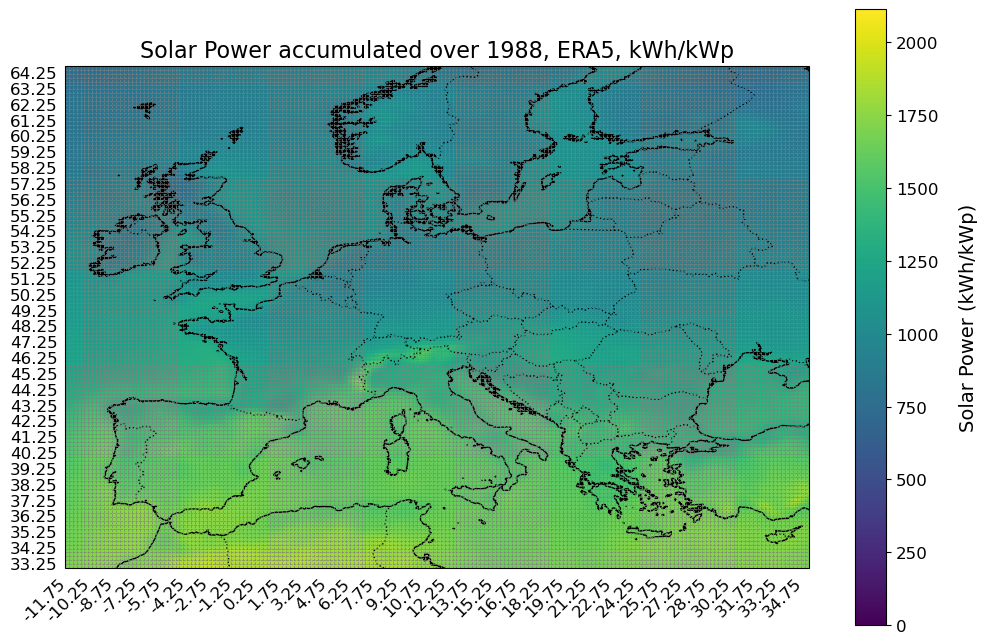

Processing model: ACCESS-CM2


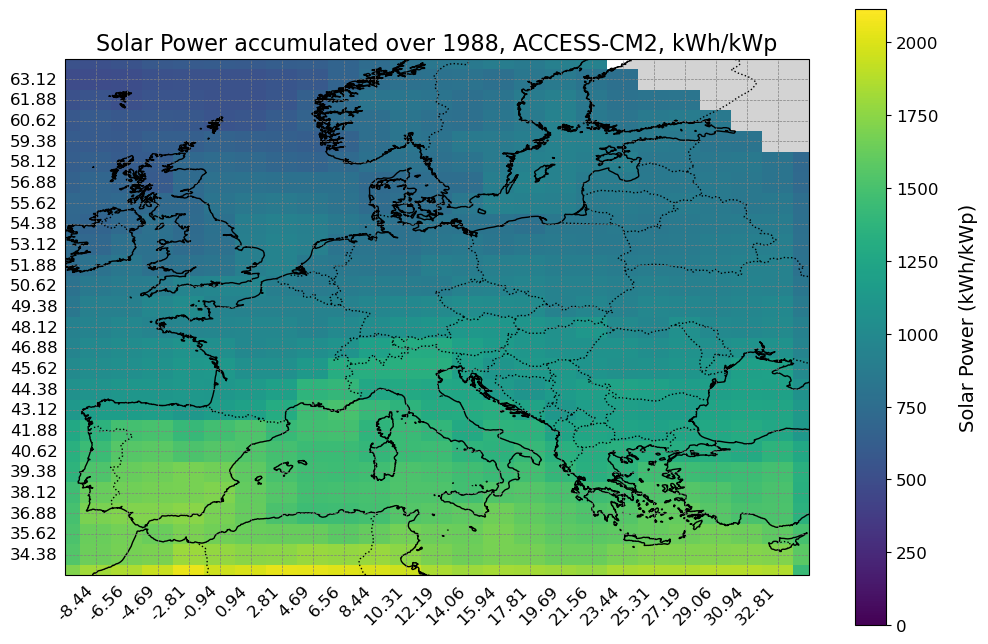

Processing model: CanESM5


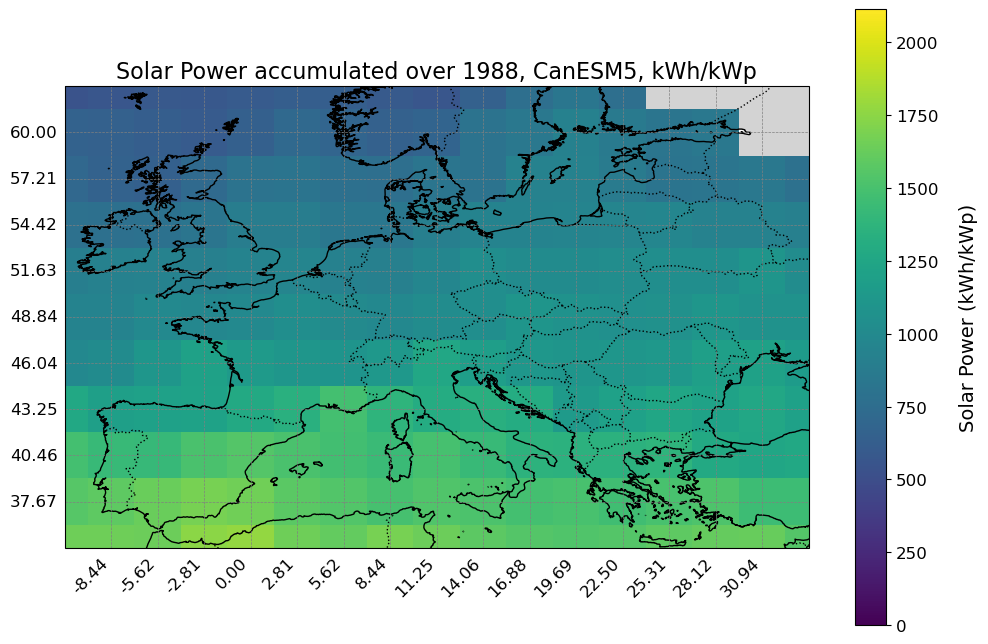

Processing model: CMCC-CM2-SR5


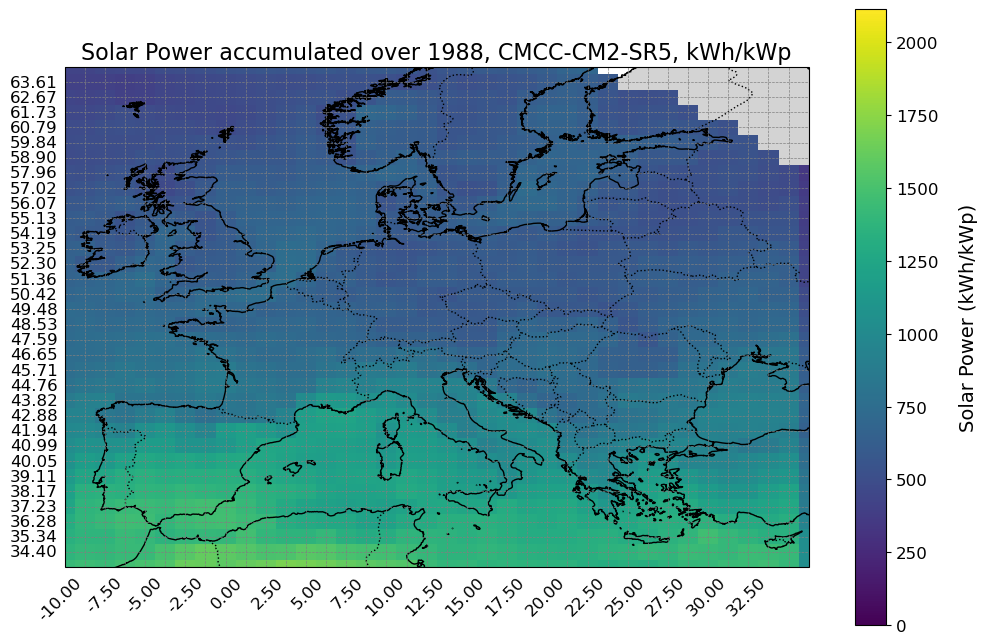

Processing model: CMCC-ESM2


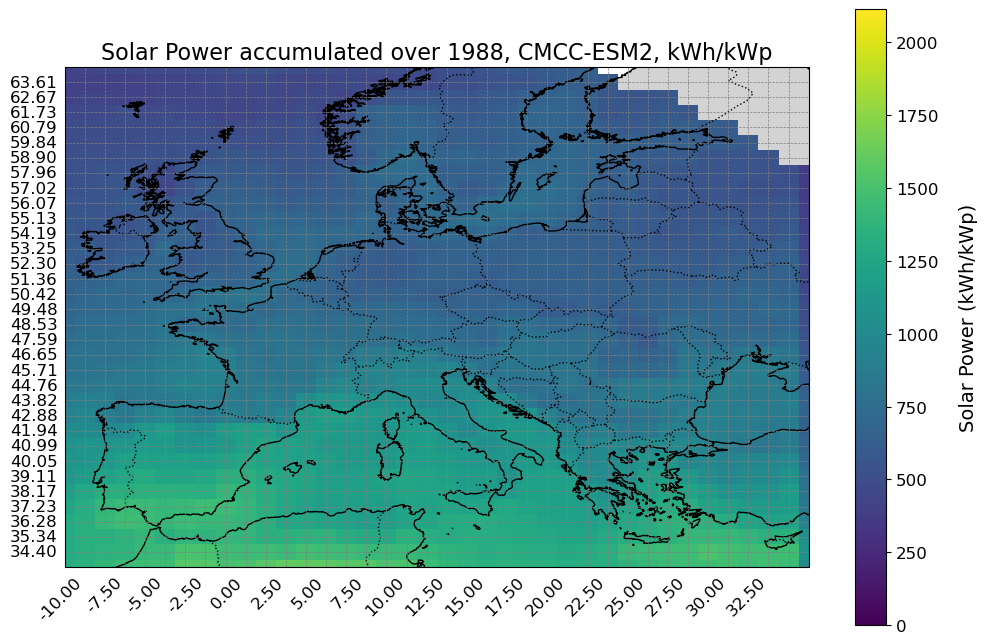

Processing model: HadGEM3-GC31-LL


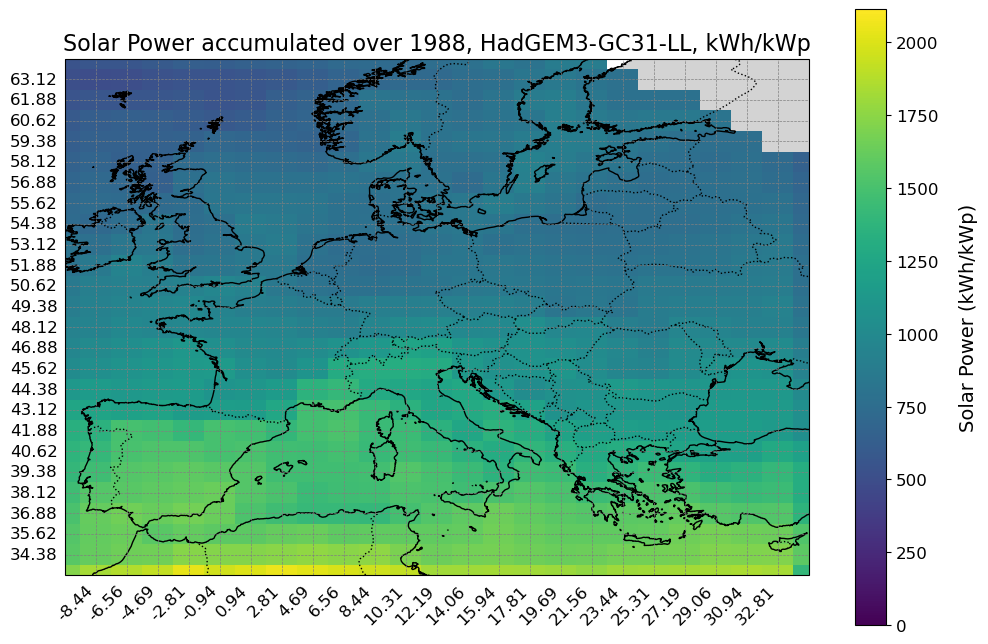

Processing model: HadGEM3-GC31-MM


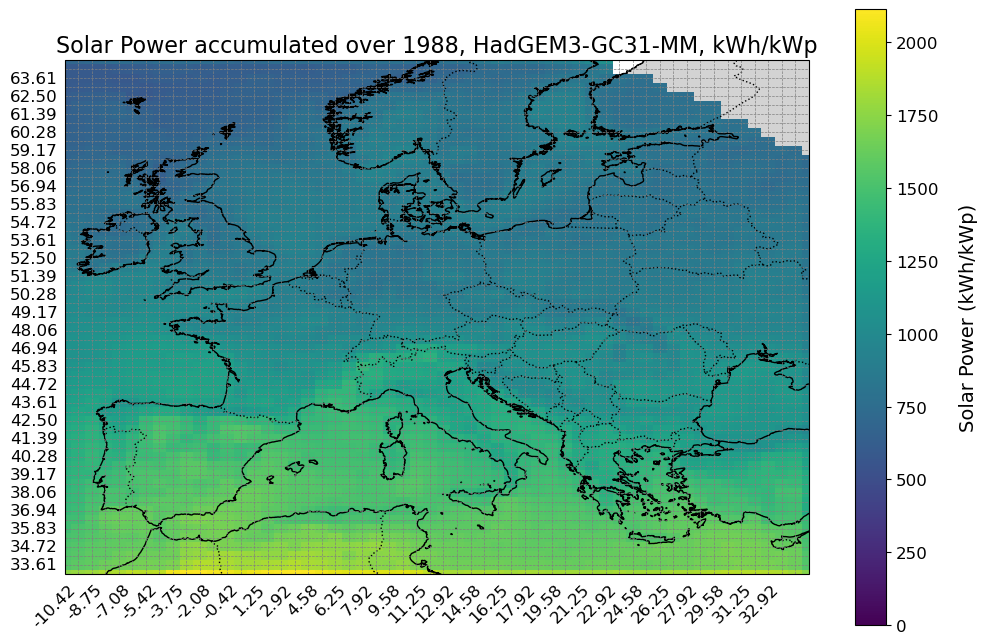

Processing model: MRI-ESM2-0


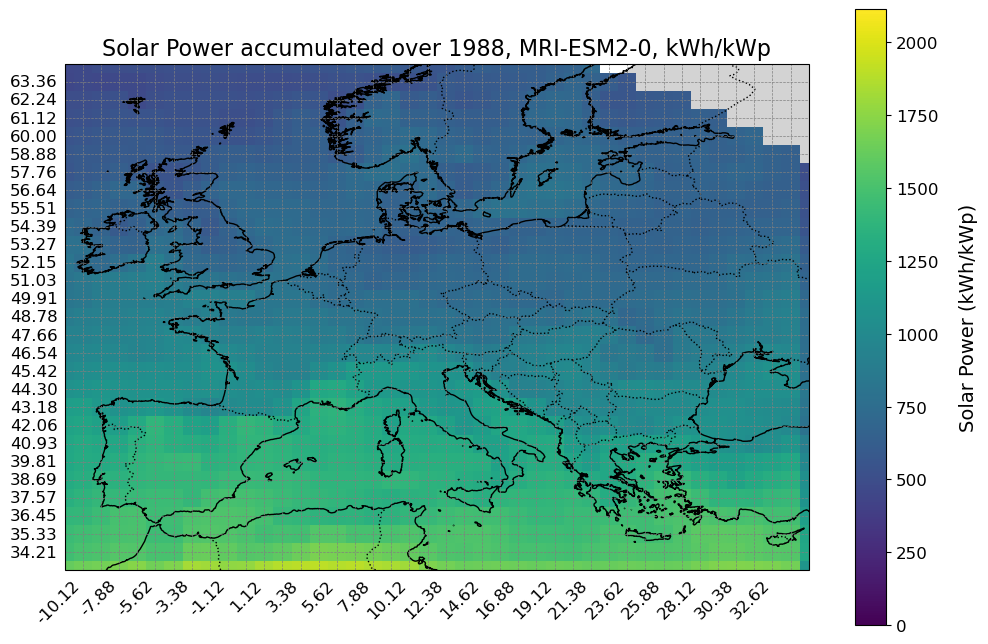

In [8]:
# Call the function to process and plot for all models
process_and_plot_models(models, base_path, region,solar_power_era5, cmap='viridis')

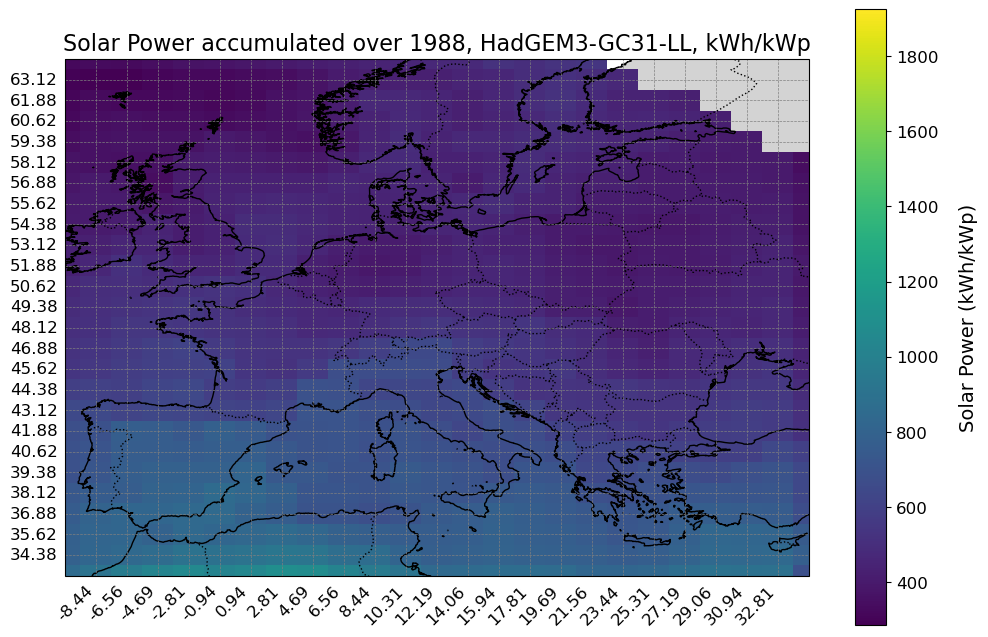

In [89]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Replace zeros with NaNs in the solar_power data
solar_power = xr.where(solar_power != 0, solar_power, float('nan'))

# Extract longitude, latitude, and the variable to plot
lon = solar_power.lon
lat = solar_power.lat  # Replace 'solar_power' with the actual variable name in ds_power

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot the solar power data
c = ax.pcolormesh(
    lon, lat, solar_power,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='viridis',  # Updated colormap for solar power
    shading='auto',
    vmin=vmin,
    vmax=vmax,  # Smooth shading
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Solar Power accumulated over 1988, HadGEM3-GC31-LL, kWh/kWp", fontsize=16)  # Increased title font size

# Add gridlines aligned with x and y coordinates
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    x_inline=False, 
    y_inline=False
)
gridlines.xlocator = plt.FixedLocator(lon.values)  # Use longitude values for x gridlines
# Reduce the number of gridlines
#gridlines.xlocator = plt.FixedLocator(np.linspace(lon.min(), lon.max(), 6))  # Use 6 evenly spaced gridlines
gridlines.ylocator = plt.FixedLocator(lat.values)  # Use latitude values for y gridlines

# Set custom formatters for longitude and latitude
gridlines.xformatter = mticker.FuncFormatter(lambda x, _: f"{x:.2f}") 
gridlines.yformatter = mticker.FuncFormatter(lambda y, _: f"{y:.2f}") 
 # Format latitude to 2 decimals

# Configure gridline labels
gridlines.top_labels = False  # Disable labels on the top
gridlines.right_labels = False  # Disable labels on the right
gridlines.xlabel_style = {'fontsize': 12, 'rotation': 45, 'ha': 'right'}  # Increased font size for x-axis labels
gridlines.ylabel_style = {'fontsize': 12}  # Increased font size for y-axis labels

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label('Solar Power (kWh/kWp)', rotation=90, labelpad=15, fontsize=14)  # Increased colorbar label font size
cbar.ax.tick_params(labelsize=12)  # Increased font size for colorbar ticks

plt.show()

In [3]:
ds_1988_Had=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-MM/historical/solar_power_1988.nc")
ds_1988_Access=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2/historical/solar_power_1988.nc")

In [7]:
ds_1988_Access

<xarray.Dataset> Size: 46MB
Dimensions:              (lat: 26, time: 8784, lon: 25)
Coordinates:
  * lat                  (lat) float32 104B 33.12 34.38 35.62 ... 63.12 64.38
  * time                 (time) datetime64[ns] 70kB 1988-01-01 ... 1988-12-31...
  * lon                  (lon) float32 100B -10.31 -8.438 -6.562 ... 32.81 34.69
Data variables:
    specific generation  (lat, time, lon) float64 46MB ...

In [8]:
ds_1988_Had

<xarray.Dataset> Size: 228MB
Dimensions:              (lat: 58, time: 8784, lon: 56)
Coordinates:
  * lat                  (lat) float32 232B 33.06 33.61 34.17 ... 64.17 64.72
  * time                 (time) datetime64[ns] 70kB 1988-01-01 ... 1988-12-31...
  * lon                  (lon) float32 224B -11.25 -10.42 -9.583 ... 33.75 34.58
Data variables:
    specific generation  (lat, time, lon) float64 228MB ...

In [22]:
# First, select the nearest lon and lat
specific_gen_Access = ds_1988_Access['specific generation'].sel(lon=2.8125, lat=41.875, method="nearest")

specific_gen_Had = ds_1988_Had['specific generation'].sel(lon=2.083333, lat=41.94445, method="nearest")

# Then, slice the time dimension
specific_gen_Access = specific_gen_Access.sel(time=slice("1988-01-01", "1988-06-30"))
specific_gen_Had = specific_gen_Had.sel(time=slice("1988-01-01", "1988-06-30"))
vmin= min(specific_gen_Access.min(), specific_gen_Had.min())
vmax= max(specific_gen_Access.max(), specific_gen_Had.max())


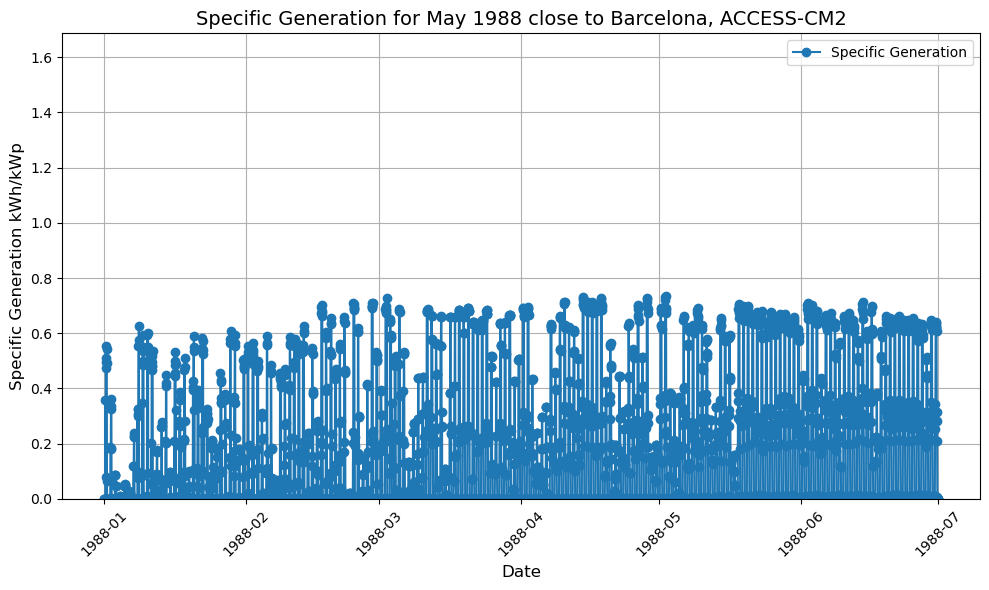

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Select the data for one month (e.g., May 1988)
#specific_gen_Access = ds_1988_Access['specific generation'].sel(lon=19.6875, lat=60.625, time=slice("1988-05-01", "1988-05-31"))

# Convert to pandas for easier plotting
specific_gen_access_df = specific_gen_Access.to_pandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(specific_gen_access_df.index, specific_gen_access_df.values, marker='o', linestyle='-', label='Specific Generation')
plt.title('Specific Generation for May 1988 close to Barcelona, ACCESS-CM2', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Specific Generation kWh/kWp', fontsize=12)
plt.ylim(vmin, vmax)  # Set y-axis limits using vmin and vmax
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

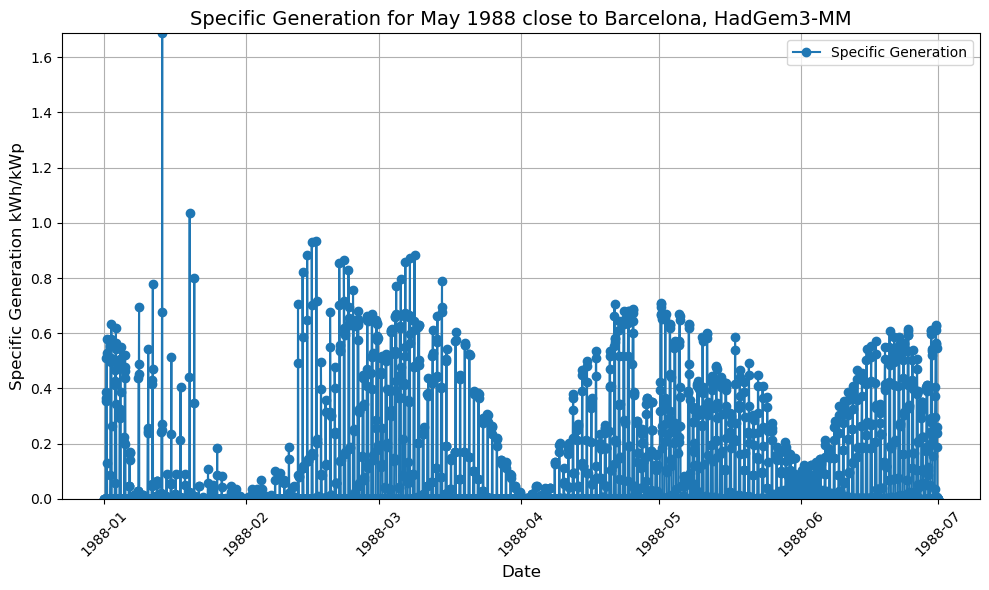

In [24]:
# Select the data for one month (e.g., May 1988)
#specific_gen_Had = ds_1988_Had['specific generation'].sel(lon=19.6875, lat=60.625, time=slice("1988-05-01", "1988-05-31"))

# Convert to pandas for easier plotting
specific_gen_had_df = specific_gen_Had.to_pandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(specific_gen_had_df.index, specific_gen_had_df.values, marker='o', linestyle='-', label='Specific Generation')
plt.title('Specific Generation for May 1988 close to Barcelona, HadGem3-MM', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Specific Generation kWh/kWp', fontsize=12)
plt.ylim(vmin, vmax)  # Set y-axis limits using vmin and vmax
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

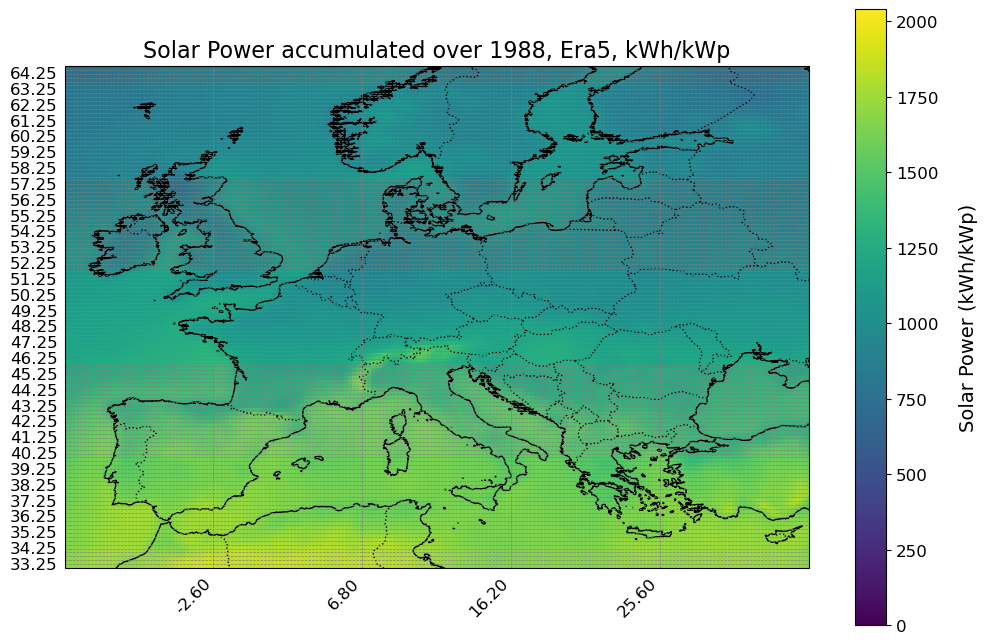

In [50]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import numpy as np

# Replace zeros with NaNs in the solar_power_era5 data
solar_power_era5 = xr.where(solar_power_era5 != 0, solar_power_era5, float('nan'))

# Extract longitude, latitude, and the variable to plot
lon = solar_power_era5.lon
lat = solar_power_era5.lat  # Replace 'solar_power_era5' with the actual variable name in ds_power

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.values.min(), lon.values.max(), lat.values.min(), lat.values.max()], crs=ccrs.PlateCarree())

# Plot the solar power data
c = ax.pcolormesh(
    lon, lat, solar_power_era5,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='viridis',  # Updated colormap for solar power
    shading='auto',
    vmin=vmin,
    vmax=vmax,  # Smooth shading
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Solar Power accumulated over 1988, Era5, kWh/kWp", fontsize=16)  # Increased title font size

# Add gridlines aligned with x and y coordinates
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    x_inline=False, 
    y_inline=False
)

# Reduce the number of gridlines for better readability
gridlines.xlocator = plt.FixedLocator(np.linspace(lon.values.min(), lon.values.max(), 6))  # Use 6 evenly spaced gridlines
gridlines.ylocator = plt.FixedLocator(lat.values)  # Use latitude values for y gridlines

# Set custom formatters for longitude and latitude
gridlines.xformatter = mticker.FuncFormatter(lambda x, _: f"{x:.2f}") 
gridlines.yformatter = mticker.FuncFormatter(lambda y, _: f"{y:.2f}") 

# Configure gridline labels
gridlines.top_labels = False  # Disable labels on the top
gridlines.right_labels = False  # Disable labels on the right
gridlines.xlabel_style = {'fontsize': 12, 'rotation': 45, 'ha': 'right'}  # Rotate and align x-axis labels
gridlines.ylabel_style = {'fontsize': 12}  # Increased font size for y-axis labels

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label('Solar Power (kWh/kWp)', rotation=90, labelpad=15, fontsize=14)  # Increased colorbar label font size
cbar.ax.tick_params(labelsize=12)  # Increased font size for colorbar ticks

plt.show()

In [47]:
albedo_file_MRI="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_MRI-ESM2-0.nc"
ds_albedo_MRI=xr.open_dataset(albedo_file_MRI)
ds_albedo_ACCESS=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_ACCESS-CM2.nc")
ds_albedo_CanESM5=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_CanESM5.nc")
ds_albedo_CMCC_CM2=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_CMCC-CM2-SR5.nc")
ds_albedo_CMCC_ESM2=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_CMCC-ESM2.nc")
ds_albedo_HadLL=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_HadGEM3-GC31-LL.nc")
ds_albedo_HadMM=xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/albedo/mean_albedo_grid_HadGEM3-GC31-MM.nc")


In [48]:
albedo_MRI=ds_albedo_MRI['__xarray_dataarray_variable__'].sel(lon=slice(-12,35), lat=slice(33,64.8))
albedo_ACCESS=ds_albedo_ACCESS['__xarray_dataarray_variable__'].sel(lon=slice(-12,35), lat=slice(33,64.8))
ds_albedo_CanESM5=ds_albedo_CanESM5['__xarray_dataarray_variable__'].sel(lon=slice(-12,35), lat=slice(33,64.8))
albedo_CMCC_CM2=ds_albedo_CMCC_CM2['__xarray_dataarray_variable__'].sel(lon=slice(-12,35), lat=slice(33,64.8))
albedo_CMCC_ESM2=ds_albedo_CMCC_ESM2['__xarray_dataarray_variable__'].sel(lon=slice(-12,35), lat=slice(33,64.8))
albedo_HadLL=ds_albedo_HadLL['__xarray_dataarray_variable__'].sel(lon=slice(-12,35), lat=slice(33,64.8))
albedo_HadMM=ds_albedo_HadMM['__xarray_dataarray_variable__'].sel(lon=slice(-12,35), lat=slice(33,64.8))

In [49]:
vmin=min(albedo_MRI.min(), albedo_ACCESS.min(), ds_albedo_CanESM5.min(), albedo_CMCC_CM2.min(), albedo_CMCC_ESM2.min(), albedo_HadLL.min(), albedo_HadMM.min())
vmax=max(albedo_MRI.max(), albedo_ACCESS.max(), ds_albedo_CanESM5.max(), albedo_CMCC_CM2.max(), albedo_CMCC_ESM2.max(), albedo_HadLL.max(), albedo_HadMM.max())

In [59]:
print(vmax)

<xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 8B
array(0.38239413)


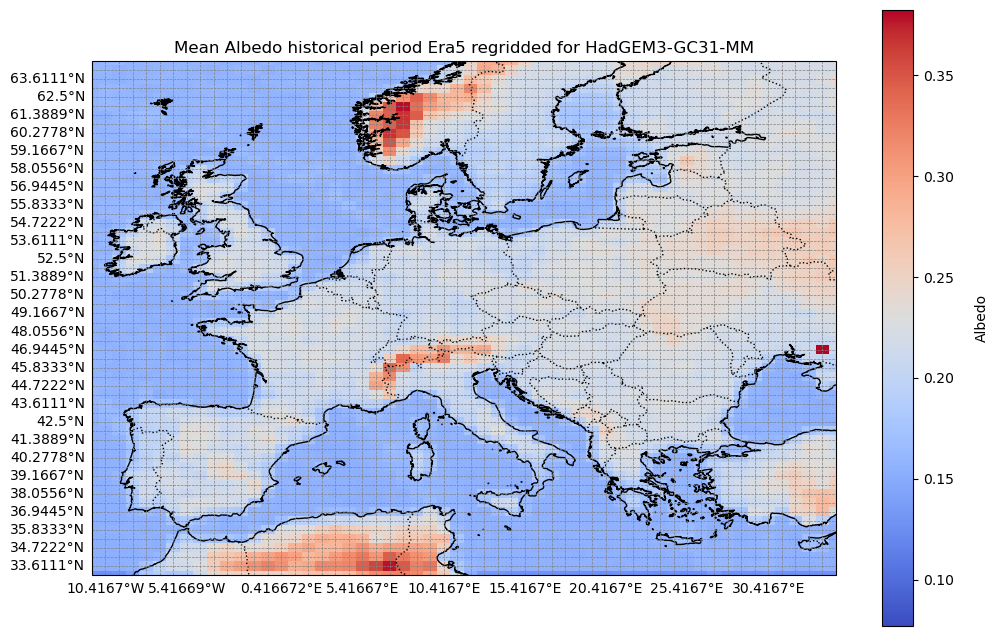

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
albedo=albedo_HadMM
# Ensure these variables are defined before running the code
lon = albedo.lon  # List or array of longitude ticks for gridlines
lat = albedo.lat  # List or array of latitude ticks for gridlines

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon, lat, albedo,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto',
    vmin=vmin,
    vmax=vmax,  # Clip extreme outliers
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Albedo historical period Era5 regridded for HadGEM3-GC31-MM")

# Add gridlines
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=lon,  # Replace with actual longitude ticks
    ylocs=lat,  # Replace with actual latitude ticks
    x_inline=False, 
    y_inline=False
)
gridlines.top_labels = False  # Disable labels on the top
gridlines.right_labels = False  # Disable labels on the right

# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical')
cbar.set_label('Albedo', rotation=90, labelpad=15)

plt.show()

In [5]:
from bias_correction import bias_factor_era5_sarah
bias_factor_era5_sarah_rsdsdiff= bias_factor_era5_sarah('influx_diffuse') #bias factor in 0.3x0.3

['/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc', '/groups/EXTREMES/cutouts/europe-2012-era5.nc', '/groups/EXTREMES/cutouts/europe-2010-era5.nc']
['/groups/EXTREMES/SARAH-3/europe-1996-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2012-sarah3-era5.nc', '/groups/EXTREMES/SARAH-3/europe-2010-sarah3-era5.nc']
189 190
157 158
157 158
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


In [8]:
from regridding_functions import read_and_average_era5_marta
from regridding_functions import read_and_average_cmip
rsdsdiff_era5_mean_BOC= read_and_average_era5_marta('influx_diffuse') #mean of era5 historical period for each grid cell
rsdsdiff_model_mean_BOC= read_and_average_cmip("/SFCRAD/CMCC-CM2-SR5/historical/r1i1p1f1/", 'rsdsdiff') #mean of model of historical period for each grid cell

['/groups/EXTREMES/cutouts/europe-1980-era5.nc', '/groups/EXTREMES/cutouts/europe-1981-era5.nc', '/groups/EXTREMES/cutouts/europe-1982-era5.nc', '/groups/EXTREMES/cutouts/europe-1983-era5.nc', '/groups/EXTREMES/cutouts/europe-1984-era5.nc', '/groups/EXTREMES/cutouts/europe-1985-era5.nc', '/groups/EXTREMES/cutouts/europe-1986-era5.nc', '/groups/EXTREMES/cutouts/europe-1987-era5.nc', '/groups/EXTREMES/cutouts/europe-1988-era5.nc', '/groups/EXTREMES/cutouts/europe-1989-era5.nc', '/groups/EXTREMES/cutouts/europe-1990-era5.nc', '/groups/EXTREMES/cutouts/europe-1991-era5.nc', '/groups/EXTREMES/cutouts/europe-1992-era5.nc', '/groups/EXTREMES/cutouts/europe-1993-era5.nc', '/groups/EXTREMES/cutouts/europe-1994-era5.nc', '/groups/EXTREMES/cutouts/europe-1995-era5.nc', '/groups/EXTREMES/cutouts/europe-1996-era5.nc', '/groups/EXTREMES/cutouts/europe-1997-era5.nc', '/groups/EXTREMES/cutouts/europe-1998-era5.nc', '/groups/EXTREMES/cutouts/europe-1999-era5.nc', '/groups/EXTREMES/cutouts/europe-2000-e

In [9]:
rsdsdiff_era5_mean_BOC=rsdsdiff_era5_mean_BOC.sel(x=slice(-12, 35), y=slice(33, 72))
rsdsdiff_model_mean_BOC=rsdsdiff_model_mean_BOC.sel(lon=slice(-12, 35), lat=slice(33, 72))

In [13]:
from regridding_functions import regrid
ds_03 = xr.open_dataset('europe_03.nc')  # grid 0.3x0.3
regridder_era5 = regrid(rsdsdiff_era5_mean_BOC, ds_03, method='conservative')  # regrid era5 to the 0.3x0.3º grid
rsdsdiff_era5_03 = regridder_era5(rsdsdiff_era5_mean_BOC)  # regridded historical mean from era5 to 0.3x0.3º grid
rsdsdiff_era5_correct = rsdsdiff_era5_03.sel(lon=slice(-12, 35), lat=slice(33, 72)) * bias_factor_era5_sarah_rsdsdiff  # apply bias factor to era5 rsds
regridder_era503_model = regrid(rsdsdiff_era5_correct, rsdsdiff_model_mean_BOC, method='conservative')  # regrid corrected era5 to the model grid
rsdsdiff_era5_correct_model = regridder_era503_model(rsdsdiff_era5_correct)  # regrid corrected era5 to the model grid
rsdsdiff_era5_correct_model = rsdsdiff_era5_correct_model.sel(lon=slice(-12, 35), lat=slice(33, 72))

189 190
157 158
157 158
131 132


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable influx_diffuse as the horizontal dimensions for the regridding.
  warnings.warn(


157 158
131 132
38 39
41 42


/home/s233224/anaconda3/envs/atlite_cmip6_2025/lib/python3.13/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('lat', 'lon') from data variable None as the horizontal dimensions for the regridding.
  warnings.warn(


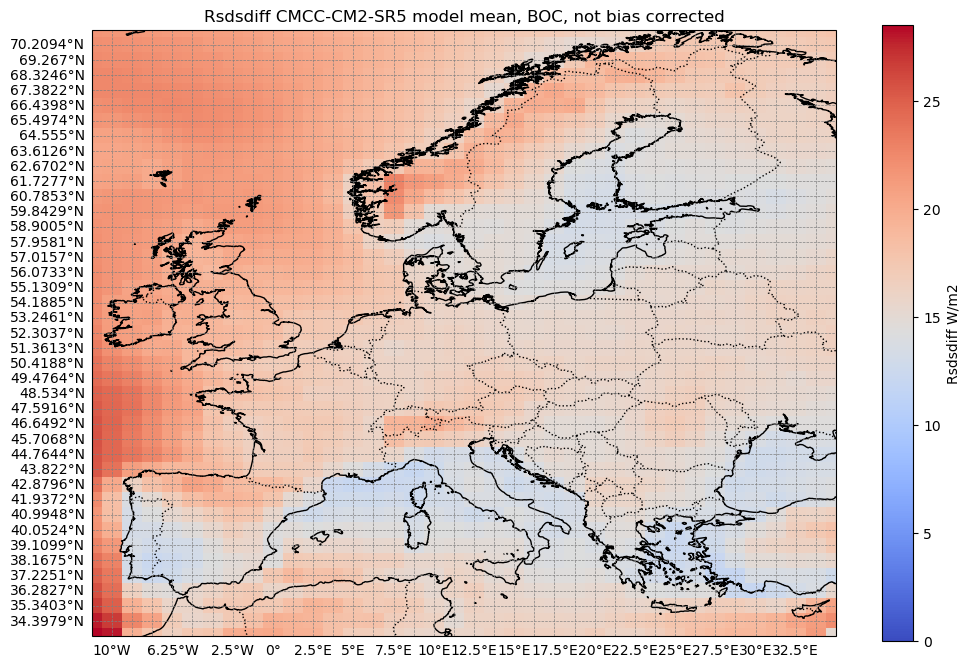

In [ ]:
# Get lat/lon values
lon = rsdsdiff_model_mean_BOC.lon.values 
lat = rsdsdiff_model_mean_BOC.lat.values

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsdsdiff_model_mean_BOC.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsdsdiff_model_mean_BOC.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, rsdsdiff_model_mean_BOC,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto' ,
    vmin=0 
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Rsdsdiff CMCC-CM2-SR5 model mean, BOC, not bias corrected")

# Add gridlines for each latitude and longitude
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=rsdsdiff_model_mean_BOC.lon, 
    ylocs=rsdsdiff_model_mean_BOC.lat, 
    x_inline=False, 
    y_inline=False
)

# Configure gridline labels
gridlines.right_labels = False  # Disable latitude labels on the right
gridlines.left_labels = True    # Enable latitude labels on the left
gridlines.top_labels = False    # Disable longitude labels on the top
gridlines.bottom_labels = True  # Enable longitude labels on the bottom
# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Rsdsdiff W/m2')

plt.show() 

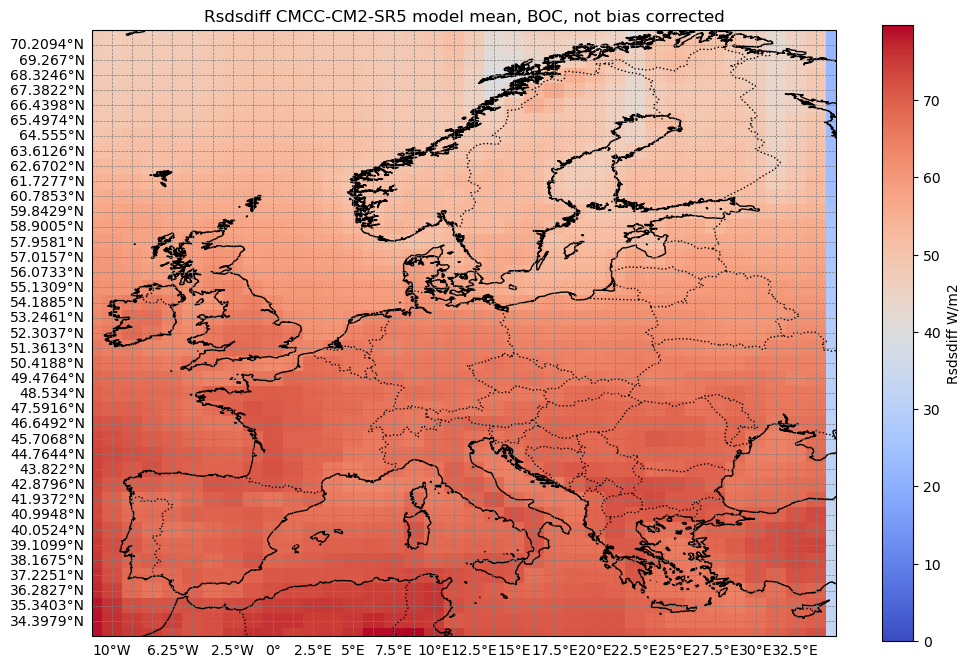

In [17]:
# Get lat/lon values
lon = rsdsdiff_model_mean_BOC.lon.values 
lat = rsdsdiff_model_mean_BOC.lat.values

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsdsdiff_model_mean_BOC.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsdsdiff_model_mean_BOC.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, rsdsdiff_era5_correct_model,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto' ,
    vmin=0 
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Mean Rsdsdiff Era5, not bias corrected")

# Add gridlines for each latitude and longitude
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=rsdsdiff_model_mean_BOC.lon, 
    ylocs=rsdsdiff_model_mean_BOC.lat, 
    x_inline=False, 
    y_inline=False
)

# Configure gridline labels
gridlines.right_labels = False  # Disable latitude labels on the right
gridlines.left_labels = True    # Enable latitude labels on the left
gridlines.top_labels = False    # Disable longitude labels on the top
gridlines.bottom_labels = True  # Enable longitude labels on the bottom
# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Rsdsdiff W/m2')

plt.show() 

In [18]:
# Assuming these variables exist
numerator_era5= rsdsdiff_era5_correct_model.values  # ERA5 dataset
denominator_era5_model= rsdsdiff_model_mean_BOC.values  # SARAH dataset

# Ensure valid bias factor calc
# ulation
mask_valid = (numerator_era5 != 0) & (denominator_era5_model != 0) # Avoid division by zero and all values in sarah that have mean 0
bias_factor_era5_model = np.where(mask_valid, numerator_era5 / denominator_era5_model, np.nan)  # Replace invalid cases with NaN

In [20]:
bias_factor_era5_model

array([[2.7574794, 2.7265642, 3.8132472, ..., 3.5717528, 3.3895729,
        2.2255592],
       [2.818831 , 2.8334131, 3.2824202, ..., 3.3936052, 3.305337 ,
        1.4835495],
       [2.926023 , 3.0254302, 3.7133672, ..., 4.0244975, 3.6458569,
        1.5701199],
       ...,
       [2.1460118, 2.1351173, 2.1698258, ..., 2.6896238, 2.8532085,
        1.2863727],
       [2.1555374, 2.1405075, 2.175907 , ..., 2.6548083, 2.7772439,
        1.2626554],
       [2.1966298, 2.1843739, 2.2039824, ..., 2.6110814, 2.7387466,
        1.2441406]], dtype=float32)

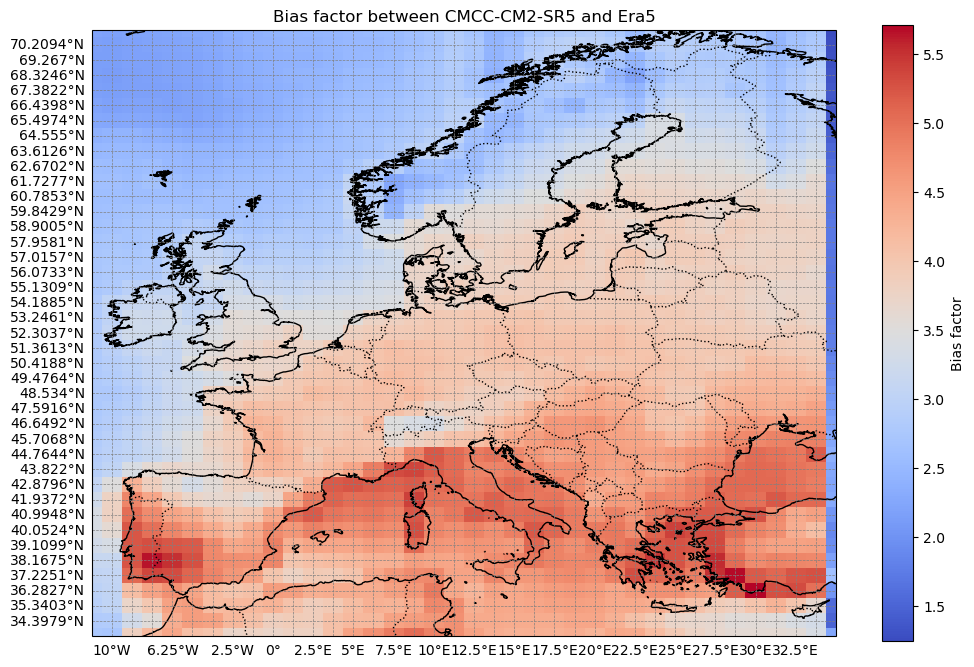

In [22]:
# Get lat/lon values
lon = rsdsdiff_model_mean_BOC.lon.values 
lat = rsdsdiff_model_mean_BOC.lat.values

lon_min, lon_max = lon.min(), lon.max()
lat_min, lat_max = lat.min(), lat.max()


# Ensure lon/lat are 2D using meshgrid
# Ensure lon/lat are 2D using meshgrid
lon_edges = np.linspace(lon.min(), lon.max(), rsdsdiff_model_mean_BOC.shape[1] )
lat_edges = np.linspace(lat.min(), lat.max(), rsdsdiff_model_mean_BOC.shape[0] )
lon2d, lat2d = np.meshgrid(lon_edges, lat_edges)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# Set the exact extent to match the dataset boundaries
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot the bias factor (masked)
c = ax.pcolormesh(
    lon2d, lat2d, bias_factor_era5_model,  # Ensure correct shapes
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Colormap for bias factor
    shading='auto' ,
)

# Add map features
ax.coastlines(resolution='10m', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.set_title("Bias factor between CMCC-CM2-SR5 and Era5")

# Add gridlines for each latitude and longitude
gridlines = ax.gridlines(
    draw_labels=True, 
    linewidth=0.5, 
    color='gray', 
    linestyle='--', 
    xlocs=rsdsdiff_model_mean_BOC.lon, 
    ylocs=rsdsdiff_model_mean_BOC.lat, 
    x_inline=False, 
    y_inline=False
)

# Configure gridline labels
gridlines.right_labels = False  # Disable latitude labels on the right
gridlines.left_labels = True    # Enable latitude labels on the left
gridlines.top_labels = False    # Disable longitude labels on the top
gridlines.bottom_labels = True  # Enable longitude labels on the bottom
# Add colorbar
cbar = fig.colorbar(c, ax=ax, orientation='vertical', label='Bias factor')

plt.show() 